# Real Estate Profit Opportunity Identification For Improvement

## Step_1: Data Wrangling

Normally, at least at this level of training, data wrangling involves cleaning up text. But we are attempting something more challenging and sophisticated - wrangling *images*. In fact, this project will involve *only* images and no text/numerical data

To do so, we start with this template with packages and tools such as TensorFlow (paired with keras), cv2 & glob

## 1. Import Packages

In [1]:
# Import the necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
import warnings

warnings.filterwarnings(action = 'ignore')

import os
import sys

import cv2 #to read images
import glob #to tell it what kind of files to read within the filepath, in this case .jpg's
import skvideo.io


In [3]:
#have to divide up these imports because taking forever so need to see what the holdup is

import tensorflow as tf


from tensorflow import keras
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image   # for preprocessing the images
from tensorflow.keras.utils import to_categorical #np_utils
from tensorflow.keras import layers
from tensorflow.keras.layers import (Flatten, Dense, Activation, MaxPooling2D, Conv2D, InputLayer)
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD

#oh nice!!! finally got all of it!

In [4]:
from numba import double, jit, njit, vectorize

import progressbar

import time

import PIL
from PIL import Image, ImageEnhance

import math

from sklearn.metrics import (confusion_matrix, classification_report, ConfusionMatrixDisplay)
from sklearn.utils import shuffle

import pickle

from skimage.transform import resize   # for resizing images

from moviepy.editor import VideoFileClip, concatenate_videoclips

## 2. Data Wrangling

In [5]:
# Establish the path to read all of the images 

#flip/not flip was the images training on which ones are examples of "pages to flip or not to flip" - that was the nature
#of this machine learning application

# path_training_flip = glob.glob('/Users/arnaldofolder/Documents/Apziva/Fourth Project/images/training/flip/*.jpg')
# path_training_notflip = glob.glob('/Users/arnaldofolder/Documents/Apziva/Fourth Project/images/training/notflip/*.jpg')
# path_testing_flip = glob.glob('/Users/arnaldofolder/Documents/Apziva/Fourth Project/images/testing/flip/*.jpg')
# path_testing_notflip = glob.glob('/Users/arnaldofolder/Documents/Apziva/Fourth Project/images/testing/notflip/*.jpg')

#######################################################################################################################

#Will use 80/20 split for training/testing, following Ahmed/Moustafa model study

#Training
path_training_flip = glob.glob('/Users/deens/OneDrive/Documents/Career/DataScienceMachineLearning/Tools/git/springboard/springboard-data-science/Capstone-2/Houses Dataset/Training Set/Flip/*.jpg')
path_training_noflip = glob.glob('/Users/deens/OneDrive/Documents/Career/DataScienceMachineLearning/Tools/git/springboard/springboard-data-science/Capstone-2/Houses Dataset/Training Set/Dont Flip/*.jpg')

#lol wow so that last slash at the very end actually DOES matter!! it didn't work without it - was getting 'empty set' error
#but it won't tell you that here for some reason

#Testing
path_testing_flip = glob.glob('/Users/deens/OneDrive/Documents/Career/DataScienceMachineLearning/Tools/git/springboard/springboard-data-science/Capstone-2/Houses Dataset/Testing Set/Flip/*.jpg')
path_testing_noflip = glob.glob('/Users/deens/OneDrive/Documents/Career/DataScienceMachineLearning/Tools/git/springboard/springboard-data-science/Capstone-2/Houses Dataset/Testing Set/Dont Flip/*.jpg')

#so what glob does is look for all files/filepaths that follow/contain a specified pattern, using the *wild card,
#so here *.jpg


#so just thought of something - the point for testing is IT'S supposed to tell us whether it thinks it should be a flip/
#not flip... so i was like then why are WE giving it the answer right off the bat!? but the thing is it doesn't realize
#we're telling it the answer. we're only doing this for our OWN purposes for organization to make it easy for ourselves/
#to see/compare ITS answers to the RIGHT answers!
#wait actually so... how does it work to tell you the 'accuracy' of the prediction at the end?
#like cuz you label the flip/not flip. so like is it just taking those images and tryna slap a label on and then
#comparing to your label? how does it not cheat/get bias? how does it do this?

## 3. Data Preprocessing

In [6]:
# Define a function that will do all the preprocessing for each image to be ready for modeling

def image_preprocessing(path):   #so with this function we'll define the filepath. in fact, that's the ONLY argument
                                 #image_preprocessing is just the name we've given to this function
    # Create an empty list to store all the preprocessed images
    images = []
    # Start by creating a for loop through all the path images and make the preprocessing to each image
    #so it'll go thru each image / file in the filepath/folder one by one, but remember the path uses GLOB so it's only
    #getting .jpg's in our case since that's what we defined/wildcarded/told it to do. there should only be .jpg's in
    #there anyway
    for i in path:
        # Firstly read the image (using the cv2)
        img = cv2.imread(i)
        # Adjust the size so all iamges will have the same size
        img = cv2.resize(img, dsize = (70,140), interpolation=cv2.INTER_CUBIC)
        #interpolation tells it how to "create new pixels" to make the image look smoother as you make it bigger,
        #rather than just stretch the original pixels and risking "pixely" images
        #bicubic is the smoothest cuz it's curved/polynomial
        # Crop to remove excess of the images we don't need for modeling, like around the border/near the edges. unnecessary noise
        #watermarks/text etc
        y,h,x,w = 0,100,0,70
        img = img[y:y+h, x:x+w] #if y & x are 0, why not just do img[y:h, x:w]?
        
        
        ####QUESTION???####
        
        
        # Adjust brightness, contrast
        alpha=1.5 #contrast/gain
        beta=0.5  #brightness/bias
        img = cv2.addWeighted(img, alpha, np.zeros(img.shape, img.dtype), 0, beta)
        #addWeighted helps to blend/transition two images together, by specifiying respective weights, like how visible
        #or transparent one is
        #the np.zeros thing is the 2nd image?? it's creating an image of 0 size and 0 dtype? what's 0 dtype?
        #is this just a way of creating a 'blank' image to make it
        #then what is 0?? the template is:
        #cv.addWeighted(image1, alpha, image2, beta, gamma[, dst[, dtype]]) #note this is cv and not cv2... any difference?
        #this is confusing cuz the *0* is in the BETA spot and BETA is in the GAMMA spot! mistake??
        #also more confusing cuz alpha & beta here are the respective WEIGHTS to give to each image
        #whereas above it had to do w/ contrast & brightness?
        #and also, it seems like for image2 we're creating a 'blank' image, which we're further giving 0 weight...
        #which poses the question - why even bother doing a blend if we're not blending?? we're only using the first
        #image by itself! well maybe we're blending an image with a blank image to attempt to create a picture with a
        #'transparent' background, like those png images! to remove any excess / nonessential background noise around the
        #main part / meat of the picture?
        #but also, shouldn't alpha & beta be on a scale of 0 to 1 and sum to 1?? Or actually, I guess you could look at
        #it as each one can be an independent percentage transparency of its full resolution, so they can both be 1
        #for example and so don't necess have to add up to 1... BUT they DO both still need to be some RATIO / can't
        #be more than 1! but alpha is 1.5??
        
        
        
        ####QUESTIONS???!!!####

        
        
        
        # Normalize the images to be black and white by reverting the images and then dividing by 255.0
        
        #this would be an important step in applications where color is irrelevant and it's just noise and you wanna focus
        #on the features. but in our application, REAL ESTATE, color is definitely very important. like if the floors are
        #modern gray, that property will def have more value
        
        #img = cv2.bitwise_not(img)  #can look up this function later
        #img = img/255               #and can look up why divide by 255

        # Append the img to the list images
        images.append(img)
        # Create the video

    # Return the list with the preprocessed images
    return images

#okay so overall, this is iterating thru our images in our path folder and reshaping/resizing/recoloring them and
#tryna crop out the background noise as much as possible?

In [7]:
# Define functions to create a video from images

#uhhh wait, why are we creating a video?? do we need that for our purposes? it's making like a slideshow?

def video_creator(path, pathIn, time, fps): #so the user is specifying: (1) the path to get the images from,
    frame_video = [] #(2) the filename to name the resultant video (will go to/in same path), (3) the length of
    for i in path: #the video?? (what units??) (don't see this used tho!!),& (4) the frames per second
        
        
         ####QUESTION???####
        
        
        img = cv2.imread(i)
        height, width, layers = img.shape   #what's layers? and i guess all 3 are defined in img.shape -- but where is
        size = (width, height)              #that defined?? in above use we seem to have made it 0/0s, but we never
        frame_video.append(img)             #stored that as like a variable?? but i guess this is just saying that
    
    out = cv2.VideoWriter(pathIn, cv2.VideoWriter_fourcc(*'mp4v'), fps, size) #make these 3 things equal to WHATEVER
    #out is just the output filepath & specs themselves but NOT
    #the act of WRITING the output itself?? that's what the below iterator
    #is for??
    
    
        ####QUESTIONS???####

    
    for i in range(len(path)):                                                #img.shape evaluates to - like it's just
        out.write(frame_video[i])                                             #a function that can be called
    
        #why do we do for i in range(len(path)) instead of just for i in path, like we did above??
        #it's a way of iterative printing by calling the index rather than simply calling the elements one by one in order
        #as it standard/ly does. but isn't calling by index what it's inherently/implicitly/automatically doing??
        #what would the length of path be anyway? cuz if path is just a text string for/giving the filepath/directory,
        #then isn't len(path) just literally the character count? i.e. number of characters in the path name?
        #but maybe this is doing the ACTUAL writing of each image to the out/put path, defined above, in accordance with
        #the specs defined in that out/put function, so it's iterating thru each image in the path and making it into
        #the final product output video?
        #so i think this process is IV/FOUR/4 steps:
        #(1) we cycle thru each image, resize,etc it
        #(2) append each of theses images to a collective/aggregated 'reel', which is just a collection of images,
        #just like how a pdf is a collection of pages, but it's not a MOVIE yet cuz it hasn't been formatted as one/to move!
        #that's what step 4 is for! the conversion/formatting. but before that, before the actual piecemeal conversion,
        #we gotta:
        #(3) set up the specs for the final output video, like as far as format type, fps, size, etc
        #(4) write each one of those pics/frames in the collective/tion to the final output conversion/formatting function "out"
        #for formatting/conversion in accordance w/ the defined/outlined specs to become a / the final video
        #product output!
        #again tho, couldn't we just have / simply achieved this by for i in frame_video: out.write(i)????
    
    
        ####QUESTIONS???####

    
    
    
    out.release()
    #officially 'releases' this video/movie to the public after its been created

#So we're cycling thru the images, defining the size of each, which will be its own frame, and these images/frames
#will be pieced together in/as a movie reel and output/written according to the specs as its formatted/converted to
#movie format

In [8]:
# Read and preprocess the training data

#so in his example/template, he's classifying diff scenarios - pages to flip and pages that shouldn't be flipped
#what am I doing?  well, i guess in a way, I'M deciding whether to FLIP or not too.... A PROPERTY!!!
#so that means I needa manually sort thru each set of pics and train it based on which houses I want renovated and
#which ones I want as is
#so gotta fine/re-tune the objective/purpose/goal here. cuz we could make it like that^, or we could do more closely
#to what we were initially thinking, which is more like the Big Mountain project, and is what the creators of the
#parent dataset project i'm using did - just take ALL the data, split randomly, and use those to train factors to come
#up with the predicted price? oh but then we'd need text data - we'd have to have baseline prices
#i'm tryna remember how we did it in Big Mountain - we had prices, and then i think: found the most important factors
#that influenced the prices, and then accordingly used those to PREDICT what prices SHOULD be, based off what everyone
#else was doing. Similarly, this Ahmed/Moustafa project was for HOUSE PRICE ESTIMATION based off images AND text/numerical
#data both!

#but I was told it gets tricky when you try to do both, even though that makes more sense - that's obviously how a human
#would work, but to do that w/ computers takes advanced neural networking / deep learning etc and I'm not quite at that
#point yet. So, we'll simplify and use images alone! that's why this makes sense that we would have to do CATEGORIES then-
#because this is traditionally used as/or at least one very common/famous example/use of this is for CLASSIFICATION!
#so basically, image/face recognition like Apple's FaceID & furry friends & laying out all the 'people' in/from your pictures
#so you can quickly go to the pictures w/ them! and of course the first famous one that i knew - Facebook's facial recognition
#for tagging suggestions where they look at your pictures, look at the faces in them, and cross ref w/ your friends'
#pictures to get matches (lol what if your friend only has like a dog / only ever has dogs as their profile pic - no humans
#so that anytime you have a dog in your pic it suggests that it's that person! >v<)
#so yeah, then if we're only doing images, we don't have any prices to train it on, we can only pre-break it up and feed
#it what's what - so what properties should be:
#Renovated/Flipped - ones that are in poorer condition


#would be great to learn how to do both images and text so we can look at/consider other factors like neighborhood etc!
#and look at the asking price, come up with a predicted ACTUAL selling price, and then estimate calculations for the cost
#of renovating and the potential PROFIT MARK-UP / PRICE WE CAN SELL IT AT ONCE WE RENOVATE!! and also give the price
#we can get if we decide to RENT IT OUT!!! and then of course provide an accompanying report of like a cash flow/RoR
#analysis!!! It may be a slightly different algorithm for rental properties as far as like what costs go into it cuz
#may not spend on the same things cuz renovating for different purposes/diff audience. completely diff cash recovery/return
#method. so the cash flow obviously will look completely diff, diff costs etc
#so in that ideal scenario, the categories could be like: Renovate-Flip To Sell, Renovate-Flip To Rent,
#Buy-As-Is=>>TURNKEY To Rent, or Pass
#(could even have it look for rental properties you wanna renovate and SELL and not rent out yourself!)
#factor in whether to pay cash or finance

#but for now, we'll keep it / start off simple and just classify as Renovate/Flip or Pass/Not Flip


#HMMMmmmm, but now that i look more closely at this dataset I have, these are almost all NICE houses that are ready to
#go and wouldn't be candidates for flipping. and these are all sfh's i believe so may not have alot of options for renting
#either, unless there are some small ones. but again, identifying / subclassifying for renting is outside of the
#scope of this most likely since we don't have text data to tell us what's a multi fam vs. a condo etc and don't have
#the square footage and 'num of dwellings' to support that

#################################################################################################################################
#SO - that may mean that i need to MANUALLY collect/develop/compile my OWN database of images!!!! both for training and testing purposes
#################################################################################################################################


####QUESTION!!!####
#In image machine learning, do we also train it on what does NOT constitute a category, so that it doesn't get confused
#by other things/special/rare circumstances it might occur and knows how to handle it?
#YES!! that's what the NOT_FLIP is for!!
#for example, with real estate, in general we'll teach it to look for stuff that's outdated, based on style and color
#(and oftentimes even low image quality alone will indicate a bad situation i.e. a GOOD opportunity to renovate/flip
#but i guess it wouldn't matter too much cuz would still needa base on elements of image). also ARRANGEMENT - like if
#things are messy/in disarray. but what about if it encounters stuff that, technically, yes, is outdated, but it's in
#SEVERE disrepair, abandoned! how will / do we teach it to NOT classify those as investment opportunities / flips but
#rather as Do Not Buy's!
#so we may need to stick to just one kind of property, i.e. single family homes, and not do like condos or townhomes
#if we're factoring in the EXTERIOR of buildings cuz that would proabably throw it off and would be better to keep those
#all separate at first and then combine / aggregate later
#BUT - we COULD use ONLY interior pictures, in which case it wouldn't matter if it's a SFH, townhome or condo - and
#actually that makes more sense to only use interior bc that's the MAIN BASIS for deciding whether something is a good
#flip or not because that's the MAIN DRIVER of price in people's minds. cuz think about it - in a condo highrise or
#townhome village, - the exterior is shared/identical! so what sets them apart that can drastically alter price!?
#(other than possibly view) >> interior design!!!


#img_training = image_preprocessing(path = path_training_flip)
#Don't need to write path since that's the only arg / in general don't need if following/aligned w/ order
#deleted the remainder originals - all like this

# Read the training not flip

img_training_flip = image_preprocessing(path_training_flip)

# Read the training not flip

img_training_noflip = image_preprocessing(path_training_noflip)

# Read the test flip

img_testing_flip = image_preprocessing(path_testing_flip)

# Read the test not flip

img_testing_noflip = image_preprocessing(path_testing_noflip)



In [9]:
# Set the labels

#so this will output 1 for EVERY element in the folder?? the label is just gonna be 1 for each element?
#and what is the y representing anyway?
#ohhh, wait, think i got it. so we wanna train this thing to know when to flip and when not to flip, so "DO flip"
#is 1, aka TRUE!!! and don't is 0, seen below
#so we're assigning a value of 1/True for EVERY item in the training
#i have to look back at Big Mountain but i think we used labels when we were labeling the points as/w/ the state names
#but here the label also represents the value

#im a little confused on doing it for the testing set tho? again gotta look at Big Mountain but why are we assigning its
#values? isn't the point that we're supposed to SEE how well it does, like it SHOULD result in 1's for flips and 0's
#for nonflips... so maybe it's just gonna use these as benchmarks of what they SHOULD/'VE BEEN so we can see how the
#actuals compare to these shoulds/ideals/theoreticals
y_train_flip = [1 for i in range(0, len(img_training_flip))]

y_train_noflip = [0 for i in range(0, len(img_training_noflip))]

y_test_flip = [1 for i in range(0, len(img_testing_flip))]

y_test_noflip = [0 for i in range(0, len(img_testing_noflip))]

In [10]:
#Okay so this uses the video_creator function we made above and supplies the needed arguments - the path (globbed)
#containing the images, the name to name/call the resultant output file, the time - which they're making as just the
#length of pictures in that folder - so is that in seconds then?? like i.e. one sec of video per photo?? and again,
#from looking at the function def, can't tell where the time is getting factored in / where it's being used to build
#the vid?


#####QUESTION#####


# # Create the video for the training flip

# #don't need the arg labels but left alone to make clearer
# video_creator(path = path_training_flip, pathIn = 'training_flip.avi', time = len(path_training_flip), fps = 1)

# # Create the video for the training not flip

# video_creator(path_training_noflip, pathIn = 'training_noflip.avi', time = len(img_training_noflip), fps = 1)

# # Create the video for the test flip

# video_creator(path_testing_flip, pathIn = 'test_flip.avi', time = len(img_testing_flip), fps = 1)

# # Create the video for the test not flip

# video_creator(path = path_testing_noflip, pathIn = 'test_noflip.avi', time = len(img_testing_noflip), fps = 1)





############NOT SURE WHY THIS IS GIVING AN ERROR, BUT GONNA LEAVE THIS OUT ANYWAY SINCE WE'RE NOT USING VIDEO!
#ERROR W/ SIZE PART OF FUNCTION: UnboundLocalError: local variable 'size' referenced before assignment


### Modeling

In [11]:
# Define the X_train, X_test, y_train and y_test for analysis

#hmm okay, so the X's are the images themselves, interesting! that's all there is to it - can summarize all of it
#to simply that!
#and the y's are what we saw before/above - 1's & 0's accordingly
#and as we see, combine/unsegregate the flips/notflips into one! cuz together they still make up the training/testing sets

#Note the difference b/w concat & append! concat defaults to stacking VERTICALLY -> axis = 0
#and append defaults to FLATTENING COMPLETELY -> fully unraveling / stretching / connecting / daisy-chaining
#ALL rows out to ONE SINGLE LONG ROW!!!

#can do any kind of 3 stackings w/ either, but best to go w/ one who has what you're looking for as the default
#so that's why we use concat for X, cuz we want those vertically stacked,
#whereas we want our y's as one single long row
#... wait WHY THO????
#so for the X's, the flips & non-flips images will be two separate rows
#for the y's, the flips & non-flips VALUES will be ONE SINGLE ROW!
#question is - which direction are img_ & train_flip orientated?? which way does append naturally stack?
#okay, so i did a basic append using an empty list, which is what it seems they did w/ image_processing, and it
#APPENDS SIDEWAYS!!! horizontal/across/left-to-right. so then our hunch was right - concatting 2 X lists of images - those
#lists are each sideways (as opposed to upright; they're 'supine' lol), so when we concat w/ axis=0, they'll be stacked
#vertically, rowswise, so yes, each of these new X vars will be 2 rows, one flip one nonflip
#okay and then checked for y's by doing a practice list comprehension and that ALSO created a sideways/-wise list!
#thus, appending two y lists on axis None will make one longe list/row!!! and actually, didn't even need to practice
#check cuz anytime doing axis None for either (concat or append), it'll first AUTOMATICALLY FLATTEN the composite
#lists regardless of orientation! so that way it can just daisy-chain them together!
#so not sure if there's a reason *WHY* both are oriented horizontal, but maybe that's the key point - maybe it's not
#that they have to be oriented one way or the other, as long as they're oriented the SAME direction!


#####QUESTION#####

#X's are two rows
X_train = np.concatenate((img_training_flip, img_training_noflip))#, axis = 0) #default axis is already 0!!!

X_test = np.concatenate((img_testing_flip, img_testing_noflip))#, axis = 0) #can leave for emphasis/making it clear

#y's are one long row
y_train = np.append(y_train_flip, y_train_noflip)#, axis = None)

y_test = np.append(y_test_flip, y_test_noflip)#, axis = None)

In [12]:
# See if the shapes match between the X_train and y_train and the X_test and y_test

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

#okay so 462 for training bc we got 253 items for flip & 209 for don't flip
#BUT WHAT THE HECK IS THE 100, 70, 3????
#isn't it only even possible for the shape to be 2-dimensional???
#or at least, isn't that what it is here, since it's two rows??
#and/but actually it's a little confusing cuz the two rows have diff num of columns
#cuz first row is flip, which has more images than non-flip - so don't know if that causes issues?
#not sure how Raghu's was divided between flip/not flip. but his also shows the 100, 70, 3
#and we got 122 items for testing bc we got 72 items for flip & 51 for don't flip

(462, 100, 70, 3)
(462,)
(122, 100, 70, 3)
(122,)


In [13]:
# Create a new array that will have the original arrays (labels and values) but they will be shuffled. 

# Create the array for the train data set
# well this is just a(n empty) LIST, but we make it an array later at the end. but can we just
#make it an/initialize an empty array NOW??

X_train_shuffle = []

# It is necessary to create a for loop with enumeration as well
for i,j in enumerate(X_train):
    # The new array would be the array containing the image plus its label
    
    
    #Hmm so enumerate prints the element along w/ its index number as a tuple pair
    #but X_train is just the set horiz list of combined flip & non-flip iamges
    #but this is saying it'll give the image + its 'label'. what's its label?
    #we talked about / set labels for the y's above, as 1's or 0's
    #but how do we tie those to these images?Okay so when we say label, we're talking
    
    #so enumerate(X_train) will give like [(0, 'img0'), (1, 'img1'), etc...]
    #so the i,j in this refer to the index position and the image, respectively-> (index, image)
    #so, this 'new_array' below makes (image, label)
    #ahh okay. so y_train is comprised of an array of 1's for/from y_train_flip & an array of 0's from
    #y_train_notflip. it's a single, combined, 1-row flattened array of all one's followed by all 0's
    #it's number of elements was designed to be exactly matched to that of/ the number of images in its respective folder
    #so y_train combined is the total number of training images, both flip and not flip
    #now X_train is the combined set of images, but the first row is flips and second is NOT flips!
    #similarly it's all the flips followed by all the nonflips
    #SO the images and their corresponding values/labels are all slated to line up!! now just need to pair them together,
    #which is exactly the point of enumerating/tupling!
    #so new_array = (j, y_train[i]) pairs them off by taking j image sequentially from X_train and pairs it off w/
    #the sequential value from/in y_train, which is lined up so it corresponds to it! so like [('img0', 1), ('img1', 1), etc...]
    #did we need to do that though?
    #couldn't we have just directly done:
    #for i,j X_train, y_train: 
        #new_array = (X_train[i], y_train[j])???
    #or even just concatted the 2 tables together?
    #like wouldn't have been really easy to simply start w/ the X_ arrays and simply add a column to them of all 1's
    #and all 0's as needed?
    #ohhh, it could be because we want them as inseparable/interlocked PAIRS cuz we're gonna SHUFFLE THEM SO NEED THEM
    #TO STAY INTACT!!!! can't do that w/ simple rows/columns/df format. this is more secure. cuz tuples are IMMUTABLE!!!
    #but couldn't we spit out tuples directly w/ /create tuple pairs using ZIP, like simply:
    #new = zip(X_train, y_train) --> so - this WOULD work if we were dealing with LISTS but NOT arrays! if you try this
    #w/ arrays, it'll simply make ONE SINGLE TUPLE out of the WHOLE first array and WHOLE second array!
    #i tried doing using a for loop but didn't work either:
    #for x, y in keys, values:
        #zip(keys[x], values[y])
        #error: 'not enough values to unpack (expected 2, got 1)'...
        #tried as/w inner loop/loop-w/in-loop, but that errored too
        #also tried as lists instead of arrays, but that said 'TOO many values to unpack'! lol - but this'd be an
        #unnecessarily long way to do it anyway for lists. if you got lists you got it easy!
    #however, these 2 things probably COULD have been set up as lists instead of arrays
    #BUT - i'm guessing there was probably a reason to set up as arrays, like maybe many of the other functions could
    #only be done if np.arrays, like shuffling
    #also, instead of appending new_array to X_train_shuffle,...
    #WHY DIDN'T WE JUST DO IT DIRECTLY!!!
    #like instead of new_array made it X_train_shuffle
    #would we even had to have initalized it? cuz didn't initialize new_array!!! thus wouldn't need to/no need to
    #do .append either if we did that!!!
    #oh wait, note. so initially the i refers to the INDEX num of X_train, cuz that's the part of enumerate
    #but then we're calling y_train[i]... well i guess that's fine. kinda like a neat workaround. iteration runs the same
    #number/order as indexes, so that works
    #hmmm, even when i tried to replicate this and do a for-loop w/ enumerate w/ arrays, it still acted the same as simply doing zip!!!
    #so i wonder-- is that what we're actually going for? or, does it just LOOK like this output/display but in actuality
    #it is tupled the way we want? i.e. in effect/practice, the elements are PAIRED-WEDDED-BONDED the way we want???
    
    
    
    #####QUESTION#####


    
    new_array = (j, y_train[i])
    # Append the values to the array (empty LIST we initialized) that will be shuffled
    X_train_shuffle.append(new_array)
    
# Have the new set of arrays
X_train_shuffle = np.array(X_train_shuffle)


#okay so we CALL IT "shuffle" but it's not shuffled at all? it's perfectly lined up? does that come later or something?
#why not do it now and finish it off?
#coulda done here:
#np.random.shuffle(X_train_shuffle)


In [14]:
# Create the array for the test data set

X_test_shuffle = []

# It is necessary to create a for loop with enumeration as well
for i,j in enumerate(X_test):
    # The new array would be the array containing the image plus its label 
    new_array = (j, y_test[i])
    # Append the values to the array that will be shuffled
    X_test_shuffle.append(new_array)
    
# Have the new set of arrays  
X_test_shuffle = np.array(X_test_shuffle)

#coulda done here:
#np.random.shuffle(X_test_shuffle)

In [15]:
# Apply the random shuffle to make the train and test with no specific order

np.random.shuffle(X_train_shuffle)

np.random.shuffle(X_test_shuffle)


In [16]:
# Separate between the X_train and y_train to fit the model

#we already have these arrays tho w/ these names... so we're overwriting them??
X_train = []
y_train = []

# Start a for loop into the X_train_shuffle
for i in X_train_shuffle:  #remem, X_train_shuffle is a set of shuffled up PAIRS of images w/ their corresponding values
                           #so that's the great thing - we don't risk mixing up the data since we're shuffling PAIRS!!! keeping them intact
    #so each 'i' is a tuple pair of (image, value)
    # The array containing the picture would be the one that is in the index 0
    value = i[0] #ohh okay, so this is referencing the 0-index of EACH i-element-tuple-pair within X_train_shuffle,
    #which is the IMAGE!! cuz i([[0],[1]]) = X_train_shuffle([[0],[1]]) = X_train_shuffle([[image],[value]])!!!
    # The label would be the array that is on the index 1
    label = i[1] #and so the 1-index-position of each tuple-pair-element in X_train_shuffle is the value!!!
    # Append the values and the labels to separate arrays
    X_train.append(value)
    y_train.append(label)

#hmmm okay, so now we store ALL the X_train images in one list(? or array?), SHUFFLED
#oh - check below - again, not shure why didn't make arrays directly up here but yeah, these above as they stand are LISTS!
#and do the same for the y-values
#BUT REMEMBER! they were shuffled TOGETHER! as PAIRS! so these will STILL line up if we wanna join em back together!
#and if they're lists we can even re-tuple/combine them now easily!


#but again - question is - why do we wanna separate em into diff lists? i get it tho that if this is something we wanted
#to do, we couldn't have simply taken these lists independently CUZ THE WHOLE POINT WAS TO TUPLE-PAIR-TIE THEM!!!
    
#but is it necessary to do a for loop to get the 'columns' of this tupled array? hmm doesn't seem so - remem how this
#'tupled' array object looks like? seems to behave how you'd expect off that - nothing you can really do w/ it?

# Divide between X_train and y_train to run model
X_train = np.array(X_train)

y_train = np.array(y_train)

In [17]:
# Same for the test data set

X_test = []
y_test = []

# Start a for loop into the X_test_shuffle
for i in X_test_shuffle:
    # The array containing the picture would be the one that is in the index 0
    value = i[0]
    # The label would be the array that is on the index 1
    label = i[1]
    # Append the values and the labels to separate arrays
    X_test.append(value)
    y_test.append(label)

X_test = np.array(X_test)

y_test = np.array(y_test)

In [18]:
# Make sure shapes are the same as their originals
#bc all we did, after all that, was essentially SHUFFLE it - didn't alter / edit / add / remove any data/points!

#?
#this shows checking the shapes/lengths of each of these arrays after we JUST updated them
#so only way to check the shape against the originals is if we made new names for these, OR have those printed out above
#also, this says/(said) 'Make sure labels are the same as the first shapes' --> i think instead of 'labels' it means
#shape presumably? so i changed it/wording

#give new names above so we can differentiate and keep rather than overwrite and compare side by side here! put text
#like print('The shape of X_train originally was %X_train.shape% and now it is %X_train_shuffled.shape%')
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(462, 100, 70, 3)
(462,)
(122, 100, 70, 3)
(122,)


In [19]:
# Define a function with the neural networks

def neural_network():  #what does it mean if it has no args again?
    model = Sequential() #?
    #whoaa - what does all this mean??
    model.add(Conv2D(32, (3, 3), activation = 'relu', kernel_initializer='he_uniform', 
                     padding = 'same', input_shape=(100, 70, 3))) #so this is the second part of the shape it gives for
    model.add(MaxPooling2D((2, 2))) #our lists, as seen right above, that i don't understand
    
    model.add(Flatten())
    
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model


#######WOWZA!!!! CAN'T WAIT TO LEARN THIS!!!##########

In [20]:
# Fit model

#little confusing - so we're naming our call of the neural_network function as 'model'
#but in the function model = Sequential()
#and then everything is built on top of / supplemented to 'model'
#like what would happen if we named the below something else? is it like w/ the way we wrote the function they/it has
#to match?

model = neural_network()

# fit model
model.fit(X_train, y_train, epochs = 15)

Epoch 1/15
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2022-01-07 08:55:16.969973: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-01-07 08:55:16.970107: W tensorflow/core/platform/profile_utils/cpu_utils.cc:126] Failed to get CPU frequency: 0 Hz


15/15 [==============================] - 1s 34ms/step - loss: 58243.5679 - accuracy: 0.5072
Epoch 2/15
15/15 [==============================] - 1s 35ms/step - loss: 0.6886 - accuracy: 0.5706
Epoch 3/15
15/15 [==============================] - 1s 34ms/step - loss: 0.6889 - accuracy: 0.5470
Epoch 4/15
15/15 [==============================] - 1s 34ms/step - loss: 0.6863 - accuracy: 0.5622
Epoch 5/15
15/15 [==============================] - 1s 34ms/step - loss: 0.6838 - accuracy: 0.5749
Epoch 6/15
15/15 [==============================] - 1s 34ms/step - loss: 0.6871 - accuracy: 0.5551
Epoch 7/15
15/15 [==============================] - 1s 34ms/step - loss: 0.6932 - accuracy: 0.5202
Epoch 8/15
15/15 [==============================] - 1s 33ms/step - loss: 0.6903 - accuracy: 0.5387
Epoch 9/15
15/15 [==============================] - 0s 33ms/step - loss: 0.6911 - accuracy: 0.5381
Epoch 10/15
15/15 [==============================] - 1s 34ms/step - loss: 0.6835 - accuracy: 0.5743
Epoch 11/15
15/1

In [21]:
# Get the predictions

predictions = model.predict(X_test)

# Get them into 0 and 1 values

binary_values = []

# Start a for loop to iterate over the predictions array

for i in predictions:
    if i < 0.5:
        binary_values.append(0)
    if i >= 0.5:
        binary_values.append(1)
        
        
#hmm okay, so it's training/fitting the model using X_train & y_train, and then from that we make predictions
#of the values of X_test to see how they compare to y_test! and so remem the predicted values will be WEIGHTED in their
#raw form, so like if we're classifying w/ 2 things/choices, it can only be one or the other, but it will spit back
#like *HOW MUCH IT THINKS/leans toward it being one or the other*, and so we have to tell it at what point/percentage/
#confidence we want it to make a call for one or the other, what's the defining/differentiating/determining/
#identifying/distinguishing/DECISION line?!!!
        

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


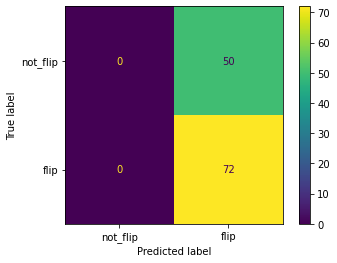

In [22]:
# Display the confusion matrix to evaluate the model

#what's that!??
#ohhhh okay, i get it now. look at the axes. so you're seeing how well the common labels lined up. i.e. where an image
#was both PREDICTED to be a flip AND was ACTUALLY a flip, as determined/stated by the label we gave it!
#so in time of writing this, it's showing, of the 102 test images, all 72 were categorized as flips were indeed labeled
#as flips. but actually,... EVERYTHING was labeled as a flip!!! so all 50 NOT FLIPS were ALSO labeled as flips!! it
#didn't label ANYTHING as a not flip!!! lol

cm = confusion_matrix(y_test, binary_values)
#so the y_test is now giving the ANSWER KEY so the algorithm can see how it did / its performance on this test/section
#so we gave the algo/machine this test set of images, combined flip and not flip so it didn't know which was which,
#all it had was the model it was trained on w/ the training set of images and corresponding labels. that was the
#instruction/guided section. this was its turn to do it on its own/try its hand at it
#so you see that it's actually very simple here, it's comparing the machine's answers, in 'binary_values', defined/
#assigned above, and comparing them to the CORRECT ANSWERS, as defined by us in y_test!!! confusion matrix is simply
#just a visual tool to help us see the performance w/ machine learning prediction performance
cmd = ConfusionMatrixDisplay(cm, display_labels=['dont_flip','flip'])
cmd.plot()

plt.show()

In [23]:
# Print the Classification report to get the precision, recall, f1-score

#whatre thoooooooose!

print(classification_report(y_test, binary_values))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        50
           1       0.59      1.00      0.74        72

    accuracy                           0.59       122
   macro avg       0.30      0.50      0.37       122
weighted avg       0.35      0.59      0.44       122



### Conclusion

###### I was able to create a model with 0.99 accuracy for whether a page needs to be flipped or not by using deep learning and doing the necessary data preprocessing such as making all the pages the same size, adjusting brightness, adding noise, etc.

In [24]:
# Save the model using pickle

#doesn't say pickle anywhere??? we did import it at start/top tho

model_classifier = model.save('flip_page_classifier')

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert

FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.


2022-01-07 08:55:25.136852: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: flip_page_classifier/assets


# Video Creation

In [25]:
#wait so what's the point of making this video?? what's different about the info we learn from a video format vs.
#picture?? they wouldn't be the same??

## Feature Engineering

In [26]:
# Establish the training video by concatenating the flips with the not flips for train and test data sets.

#Establish the train video

video_1 = VideoFileClip('training_flip.avi')
video_2 = VideoFileClip('training_notflip.avi')

training_video = concatenate_videoclips([video_1, video_2])

training_video.write_videofile('training_video.avi', codec = 'rawvideo')
training_video.close()

OSError: MoviePy error: the file training_flip.avi could not be found!
Please check that you entered the correct path.

In [ ]:
# Establish the test video

video_3 = VideoFileClip('test_flip.avi')
video_4 = VideoFileClip('test_notflip.avi')

test_video= concatenate_videoclips([video_3, video_4])

test_video.write_videofile('test_video.avi', codec = 'rawvideo')
test_video.close()

In [ ]:
# Separate the frames for the training video

count = 0

videoFile = 'training_video.avi'
# Capturing the video from the given path
cap = cv2.VideoCapture(videoFile)   
# Establish Frame rate
frameRate = cap.get(5) 

x=1

filenames_train = []

while(cap.isOpened()):
    frameId = cap.get(1) #current frame number
    ret, frame = cap.read()
    if (ret != True): 
        break
    if (frameId % math.floor(frameRate) == 0):
        filename ="frame%d.jpg" % count;count+=1
        filenames_train.append(filename)
        cv2.imwrite(filename, frame)
cap.release()
cv2.destroyAllWindows()

In [ ]:
# Separate the frames from the test video

count = 0

videoFile = 'test_video.avi'
# Capturing the video from the given path
cap = cv2.VideoCapture(videoFile)   
# Establish Frame rate
frameRate = cap.get(5) 

x=1

filenames_test = []

while(cap.isOpened()):
    frameId = cap.get(1) #current frame number
    ret, frame = cap.read()
    if (ret != True):
        break
    if (frameId % math.floor(frameRate) == 0):
        filename ="frame%d.jpg" % count;count+=1
        filenames_test.append(filename)
        cv2.imwrite(filename, frame)
cap.release()
cv2.destroyAllWindows()

In [ ]:
# Append the y_train flip and not flip into the same array

y_train = np.append(np.array(y_train_flip), np.array(y_train_notflip))

# Append the y_test flip and not flip into the same array

y_test = np.append(np.array(y_test_flip), np.array(y_test_notflip))

# Create the data frame that will show the frameID and the class for the train data

data_train = pd.DataFrame({'frameID': filenames_train, 'flip': y_train})

# Create the data frame that will show the frameID and the class for the test data

data_test = pd.DataFrame({'frameID': filenames_test, 'flip': y_test})


In [ ]:
# Randomly change the data order and reset the index

data_train = shuffle(data_train).reset_index(drop = True)

data_test = shuffle(data_test).reset_index(drop = True)

In [ ]:
# Create an empty array

X_train = []   

# Loop through the frameID column and store every frame in X
for img_name in data_train.frameID:
    img = plt.imread('' + img_name)
    X_train.append(img)  
    
# Convert the list to an array
X_train = np.array(X_train)    

# Define the y_train

y_train = data_train['flip'].values

In [ ]:
# Create an empty array

X_test = []   

# Loop through the frameID column and store every frame in X
for img_name in data_test.frameID:
    img = plt.imread('' + img_name)
    X_test.append(img)  
    
# Convert the list to an array

X_test = np.array(X_test) 

# Define the y_test

y_test = data_test['flip'].values

In [ ]:
# Define a function to do the preprocessing for each frame of image of the video

def image_preprocessing_frame(data):
    # Create an empty list to store all the preprocessed images
    images = []
    # Start by creating a for loop through all the path and make the preprocessing to each image
    for i in data:
        # Adjust the size so all iamges will have the same size
        img = cv2.resize(i, dsize = (70,140), interpolation=cv2.INTER_CUBIC)
        # Crop to remove part of the images I don't need for the modeling part
        y,h,x,w = 0,100,0,70
        img = img[y:y+h, x:x+w]
        # Adjust brightness, contrast
        alpha=1.5
        beta=0.5
        img = cv2.addWeighted(img, alpha, np.zeros(img.shape, img.dtype), 0, beta)
        # Append the img to the list images
        images.append(img)
        # Create the video

    # Return the list with the preprocessed images
    return images

In [ ]:
# Use the defined function to preprocess the data

X_train = image_preprocessing_frame(data = X_train)

X_test = image_preprocessing_frame(data = X_test)

In [ ]:
# Include_top=False to remove the top layer and a base model

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(100, 70, 3))    

In [ ]:
# Convert the list into arrays

X_train = np.array(X_train)

X_test = np.array(X_test)

In [ ]:
# We will make predictions using this model for X_train and X_valid, get the features, and then use those 
# features to retrain the model.

X_train = base_model.predict(X_train)

X_test = base_model.predict(X_test)

X_train.shape, X_test.shape

In [ ]:
# Centering the data

X_train = X_train/X_train.max()

X_test = X_test/X_test.max()

## Modeling

In [ ]:
# Define the neural network to use to predict if the frame of the video is flip or not flip

def model_neural():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation = 'relu', kernel_initializer='he_uniform', 
                     padding = 'same', input_shape=(3, 2, 512)))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Flatten())
    
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
# Use the function with the created model

model = model_neural()

model.fit(X_train, y_train, epochs = 100, validation_data = (X_test, y_test))

In [ ]:
# Get the predictions

predictions = model.predict(X_test)

# Get them into 0 and 1 values

binary_values = []

# Start a for loop to iterate over the predictions array

for i in predictions:
    if i < 0.5:
        binary_values.append(0)
    if i >= 0.5:
        binary_values.append(1)
        

## Evaluation of the Model

In [ ]:
# Display the confusion matrix to evaluate the model

cm = confusion_matrix(y_test, binary_values)
cmd = ConfusionMatrixDisplay(cm, display_labels=['not_flip','flip'])
cmd.plot()

plt.show()

In [ ]:
# Print the Classification report to get the precision, recall, f1-score

print(classification_report(y_test, binary_values))